# Critical points for various fluids


**Code:** #113-000

**File:** `apps/van_der_waals/critical_points.ipynb`

**Run it online:** [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/jongablop/MinervaLab/master?urlpath=%2Fnotebooks%2Fapps%2Fvan_der_waals%2Fcritical_points.ipynb)


-----------

The aim of this notebook is to visualize the critical points of various fluids.

## Interface

The main interface (``main_block_113_000``) is divided in three VBox: ``top_block_113_000``, ``middle_block_113_000`` and ``bottom_block_113_000``. 
``top_block_113_000`` contains a bqplot Figure (``fig_113_001``) and a qgrid chart (``qgrid_table``).
``middle_block_113_000`` contains of 3 bqplot Figures: ``fig_113_002``, ``fig_113_003`` and ``fig_113_005``.  

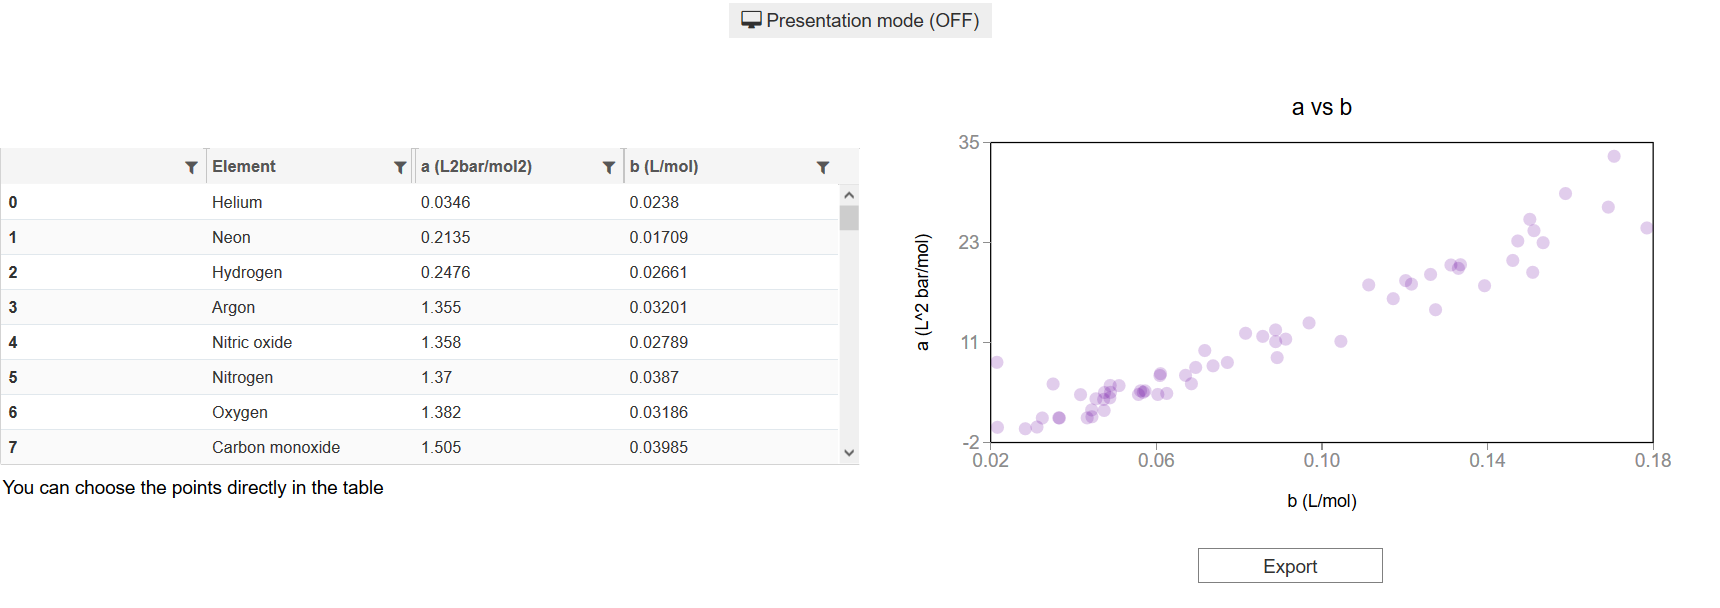

In [2]:
from IPython.display import Image
Image(filename='../../static/images/113-000_1.png')

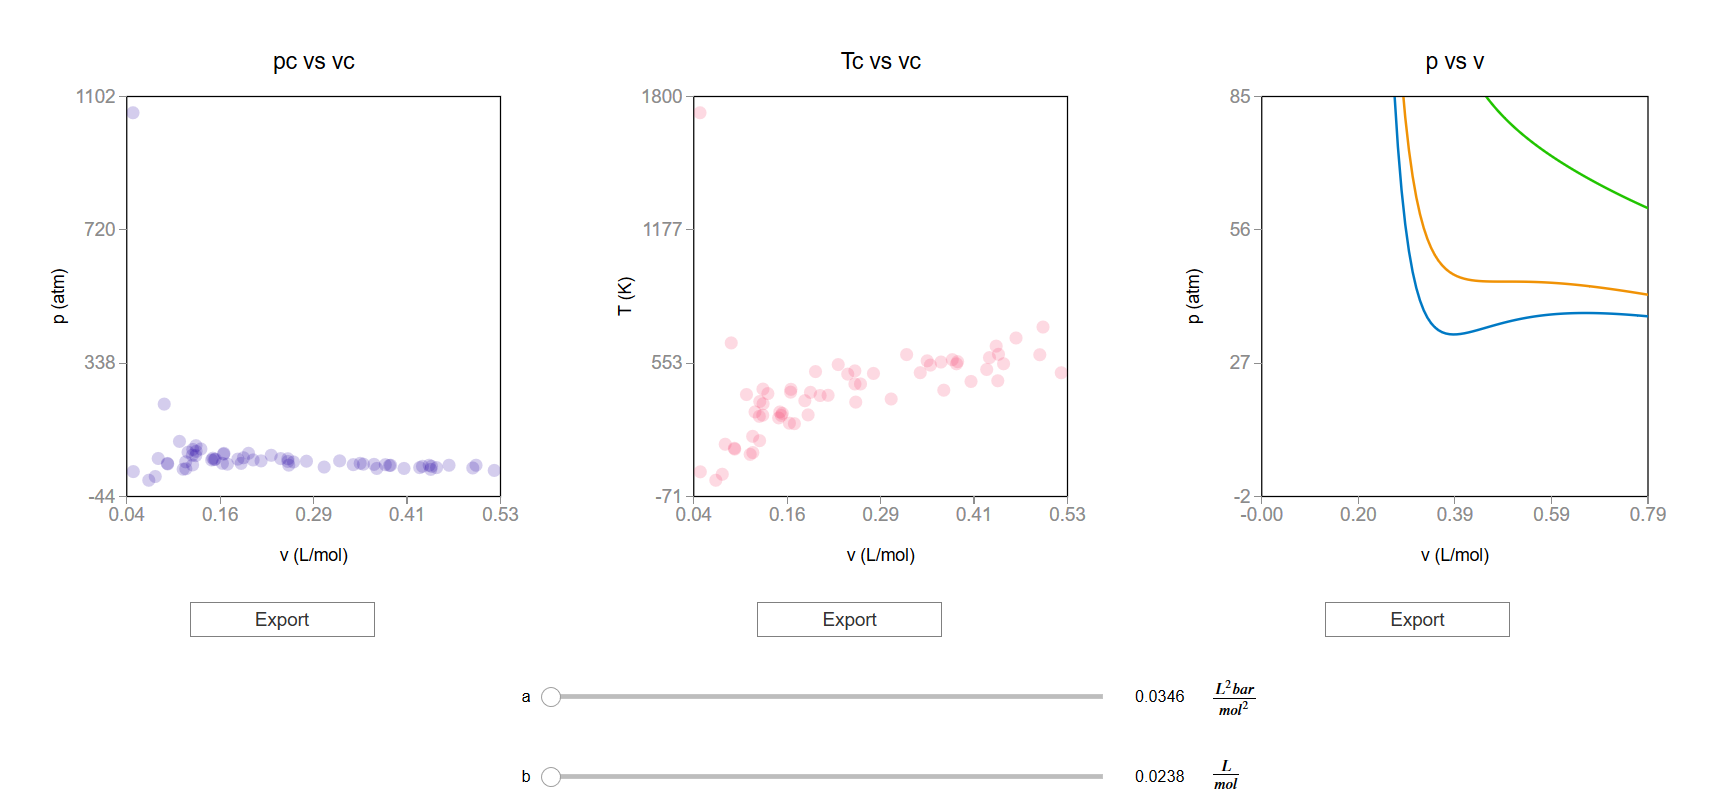

In [3]:
Image(filename='../../static/images/113-000_2.png')

## CSS
A custom `css` file is used to improve the interface of this application. It can be found [here](https://github.com/jongablop/MinervaLab/blob/master/static/custom.css).

In [1]:
from IPython.display import HTML
display(HTML("<head><link rel='stylesheet' type='text/css' href='./../../static/custom.css'></head>"))
display(HTML("<style>.container { width:100% !important; }</style>"))

## Packages

In [2]:
from bqplot import *
import bqplot as bq
import bqplot.marks as bqm
import bqplot.scales as bqs
import bqplot.axes as bqa

import ipywidgets as widgets

import scipy

import qgrid
import pandas as pd

import urllib.parse
import webbrowser

import sys

## Physical functions

This are the functions that have a physical meaning:
- `calculate_critic`
- `get_absolute_isotherms`
- `bar_to_atm`

In [3]:
def calculate_critic(a, b):
    
    """
        This function calculates the critic point 
        (p_c, v_c, T_c) from given a and b parameters of 
        the Van der Waals equation of state for real gases.
        
        :math:`(P + a \\frac{n^2}{V^2})(V - nb) = nRT`
        
        :math:`p_c = \\frac{a}{27 b^2}`
        :math:`v_c = 3b`
        :math:`T_c = \\frac{8a}{27 b R}`
        
   Args:
       a: Term related with the attraction between particles in
       L^2 bar/mol^2.\n
       b: Term related with the volume that is occupied by one 
       mole of the molecules in L/mol.\n
       
   Returns:
       p_c: Critical pressure in bar.\n
       v_c: Critical volume in L/mol.\n
       T_c: Critical tenperature in K.\n
        
    """
    
    if b == 0.0:
        return None
    
    k_B = 1.3806488e-23 #m^2 kg s^-2 K^-1
    N_A = 6.02214129e23 
    R = 0.082 * 1.01325 #bar L mol^-1 K^-1
    
    p_c = a/27.0/(b**2)
    v_c = 3.0*b
    T_c = 8.0*a/27.0/b/R
    
    return p_c, v_c, T_c

In [4]:
def get_absolute_isotherms(a, b, v_values, T_values):
    """This function calculates the theoretical p(v, T) plane 
        (in absolute coordinates) according to van der Waals
        equation of state from a given range of volumes
        and tenperatures.

    Args:
        a: Term related with the attraction between particles in
           L^2 bar/mol^2.\n
        b: Term related with the volume that is occupied by one 
        mole of the molecules in L/mol.\n
        v_values: An array containing the values of v
        for which the isotherms must be calculated.\n
        T_values: An array containing the values of T for which
        the isotherms must be calculated.\n

        
    Returns:
        isotherms: A list consisted of numpy arrays containing the
        pressures of each isotherm.
    """
    isotherms = []

    R = 0.082 * 1.01325 #bar L mol^-1 K^-1

    for T in T_values:
        
        isot = []
        
        for v in v_values:
            
            p = R*T/(v - b) - (a/v**2)
            isot = np.append(isot, p)
            
        isotherms.append(isot)
        
    return isotherms

In [5]:
def bar_to_atm(p_values):
    """This function changes the pressures of an array
    form bars to atm.
    
    Args:
        p_values: List consisted of pressures in bars.\n
        
    Returns:
        p_values: List consisted of pressures in atm.\n
    """
    
    p_values = np.array(p_values) * 0.9869 
        
    return p_values

In [6]:
def generate_critical_points(df):
    """This function takes a Pandas dataframe containing three
    columns (element, a, b) and returns four lists: pc, vc, Tc and names
    
    Args:
        df: Pandas dataframe consisted of three columns: element, a, b.\n
        
    Returns:
        pc: A numpy array consisted of the values of the critical pressures.\n
        vc: A numpy array consisted of the values of the critical volumes.\n
        Tc: A numpy array consisted of the values of the critical tenperatures.\n
        names: A list consisted of the names of the elements.\n
    """

    pc = []
    vc = []
    Tc = []
    
    names = []
    
    name_values = df.iloc[:,0]
    a_values, b_values, names_sorted = get_a_b_names(df)
    
    for i in range(len(a_values)):

        names.append(names_sorted[i])
        
        a = float(a_values[i])
        b = float(b_values[i])       
        p, v, T = calculate_critic(a, b)
        
        pc = np.append(pc, p)
        vc = np.append(vc, v)
        Tc = np.append(Tc, T)

    return pc, vc, Tc, names

In [7]:
def get_a_b_names(df):
    """This function takes a pandas dataframe containing the
    columns 'a (L2bar/mol2)', 'b (L/mol)' and 'Element' and return the
    lists of the colums sorted by the values of 'a (L2bar/mol2)'.
    
    Args:
        df: Pandas dataframe consisted of three columns: 'a (L2bar/mol2)',
        'b (L/mol)' and 'Element'.\n
        
    Returns:
        a_values_sorted: A list array consisted of the sorted values of 'a (L2bar/mol2)'.\n
        b_values_sorted: A list array consisted of the sorted values of 'b (L/mol)'.\n
        names_sorted: A list consisted of the names of the sorted values of 'Element'.\n
    """
    
    a_values = list(df['a (L2bar/mol2)'])
    b_values = list(df['b (L/mol)'])
    names = list(df['Element'])
    
    a_values_sorted = sorted(a_values)
    
    #Sort values of b depending on the order of a
    b_values_sorted = [y for _,y in sorted(zip(a_values, b_values))] 
    names_sorted = [y for _,y in sorted(zip(a_values, names))]
    
    return a_values_sorted, b_values_sorted, names_sorted

## Functions related to the interaction

In [8]:
def change_visible_points(event, QGridWidget):
    """This function changes the visible points in 
    fig_113_002, fig_113_003 and fig_113_004 according to
    the values filtered in qgrid_table.
    """
    
    i = QGridWidget.get_changed_df().index
    
    new_pc = pc[i]
    new_vc = vc[i]
    new_Tc = Tc[i]
    
    new_names = np.asarray(names_sorted)[i].tolist()

    new_a_values = np.asarray(a_values)[i].tolist()
    new_b_values = np.asarray(b_values)[i].tolist()

    scale_x_v = bqs.LinearScale(min = min(new_vc), max = max(new_vc))
    scale_y_p = bqs.LinearScale(min = min(new_pc), max = max(new_pc))
    scale_y_T = bqs.LinearScale(min = min(new_Tc), max = max(new_Tc))
    
    scale_x_004 = bqs.LinearScale(min = min(new_b_values), max = max(new_b_values))
    scale_y_004 = bqs.LinearScale(min = min(new_a_values), max = max(new_a_values))

    axis_x_v.scale = scale_x_v
    axis_y_p.scale = scale_y_p
    axis_y_T.scale = scale_y_T
    
    axis_x_004.scale = scale_x_004
    axis_y_004.scale = scale_y_004
    
    fig_113_002.axes = [axis_x_v, axis_y_p]
    fig_113_003.axes = [axis_x_v, axis_y_T]
    fig_113_004.axes = [axis_x_004, axis_y_004]
    
    for mark in fig_113_002.marks:
        
        mark.scales = {
            'x': scale_x_v,
            'y': scale_y_p
        }

    for mark in fig_113_003.marks:
        
        mark.scales = {
            'x': scale_x_v,
            'y': scale_y_T
        }
    
    fig_113_002.marks[0].x, fig_113_002.marks[0].y = new_vc, new_pc
    fig_113_002.marks[0].names = new_names
    
    fig_113_003.marks[0].x, fig_113_003.marks[0].y = new_vc, new_Tc
    fig_113_003.marks[0].names = new_names
    
    for mark in fig_113_004.marks:
        
        mark.scales = {
            'x': scale_x_004,
            'y': scale_y_004
        }
    
    update_slider_options(new_a_values, new_b_values)

In [9]:
def change_selected_points(event, QGridWidget):
    """This function changes the selected points in 
    fig_113_002 and fig_113_003 according to
    the values selected in qgrid_table.
    """
    
    i = QGridWidget.get_changed_df().index

    new_pc = pc[i]
    new_vc = vc[i]
    new_Tc = Tc[i]
    
    new_names = np.asarray(names_sorted)[i].tolist()
    
    selected_113_002.x, selected_113_002.y = new_vc, new_pc
    selected_113_002.names = new_names
    
    selected_113_003.x, selected_113_003.y = new_vc, new_Tc
    selected_113_003.names = new_names

In [10]:
def update_slider_options(a_values, b_values):
    """This function changes the options of
    a_slider and b_slider sliders.
    
    Args:
        a_values: List consisted of a_slider's new options.\n
        b_values: List consisted of b_slider's new options.\n
    """
    
    a_slider.options = a_values
    b_slider.options = b_values
    
    a_slider.value = a_values[0]
    b_slider.value = b_values[0]

In [11]:
def update_sliders(change):
    """This function updates the visible mark in
    fig_113_005 and the tracers tracer_113_002 and
    tracer_113_003.\n
    """
    
    index = change.get('owner').index
    name = change.get('owner').description
    
    if name == 'a':
        
        b_slider.value = b_slider.options[index]
    
    elif name == 'b':
        
        a_slider.value = a_slider.options[index]
        
    tracer_113_002.x = np.array([scatter_113_002.x[index]])
    tracer_113_002.y = np.array([scatter_113_002.y[index]])
    
    tracer_113_003.x = np.array([scatter_113_003.x[index]])
    tracer_113_003.y = np.array([scatter_113_003.y[index]])
    
    i = a_values.index(a_slider.value)
    element_name = fig_113_005.marks[i].labels[0]
    
    tracer_113_002.names = [element_name]
    tracer_113_003.names = [element_name]
    
    for mark in fig_113_005.marks:
        
        if mark.labels[0] == element_name:
            
            mark.visible = True
            
        else:
            
            mark.visible = False

In [12]:
tt = widgets.Label("")

def hover_handler(self, content):
    tt.value = str(content.get('data').get('name'))

In [13]:
def change_view(change):
    """This function changes the visualization of all the
    components of the application so they are suitable for
    a projection.\n
    """
    
    obj = change.owner

    if obj.value:
        
        obj.description = 'Presentation mode (ON)'
        
        display(HTML(
            "<style>" \
            ".widget-readout { font-size: 30px ; }" \
            ".widget-label-basic {font-size: 30px;}" \
            "option {font-size: 25px;}" \
            ".p-Widget.jupyter-widgets.widget-slider.widget-vslider.widget-inline-vbox {width: auto}" \
            ".p-Widget .jupyter-widgets .widgets-label {width: auto; height: auto; font-size: 30px;}" \
            ".widget-label {font-size: 30px ; height: auto !important;}" \
            ".p-Widget .bqplot .figure .jupyter-widgets {height: auto !important;}" \
            ".widget-text input[type='number'] {font-size: 30px;height: auto;}" \
            ".option { font-size: 30px ;}" \
            ".p-Widget .jupyter-widgets .jupyter-button.widget-button {font-size: 30px ; width: auto; height: auto;}" \
            ".p-Widget.jupyter-widgets.jupyter-button.widget-toggle-button{font-size: 30px ; width: auto; height: auto;}" \
            ".p-Widget.p-Panel.jupyter-widgets.widget-container.widget-box.widget-vbox {padding-bottom: 30px}" \
            ".bqplot > svg .axis text.axislabel, .bqplot > svg .axis tspan.axislabel {font-size: 30px;}" \
            ".q-grid .slick-cell {font-size: 30px;}" \
            ".slick-column-name {font-size: 30px;}"
            "</style>"
            )
        )

        for figure in figures:
            
            figure.legend_text = {'font-size': '30px'}
            figure.title_style = {'font-size': '30px'}

            for axis in figure.axes:
                axis.tick_style = {'font-size': '30px'}
                axis.label_style = {'font-size': '30px'}
        
    else:
        
        obj.description = 'Presentation mode (OFF)'
        
        display(HTML(
            "<style>" \
            ".widget-readout { font-size: 14px ;}" \
            ".widget-label-basic {font-size: 14px;}" \
            "option {font-size: 12px;}" \
            ".p-Widget .jupyter-widgets .widgets-label {font-size: 14px;}" \
            ".widget-label {font-size: 14px ;}" \
            ".widget-text input[type='number'] {font-size: 14px;}" \
            ".option { font-size: 14px ;}" \
            ".p-Widget .jupyter-widgets .jupyter-button.widget-button {font-size: 14px;}" \
            ".p-Widget.jupyter-widgets.jupyter-button.widget-toggle-button {font-size: 14px;}" \
            ".bqplot > svg .axis text.axislabel, .bqplot > svg .axis tspan.axislabel {font-size: 14px;}" \
            ".q-grid .slick-cell {font-size: 14px;}" \
            ".slick-column-name {font-size: 14px;}"
            "</style>"
            )
        )
        
        for figure in figures:
            
            figure.legend_text = {'font-size': '14px'}
            figure.title_style = {'font-size': '20px'}

            for axis in figure.axes:
                axis.tick_style = {'font-size': '14px'}
                axis.label_style = {'font-size': '14px'}

In [14]:
def prepare_export(button):
    """This function sends the selected plot to the 'export_plot'
    function.
    """
    
    if button is prepare_export_fig_113_002_button:
        
        export_plot(fig_113_002)
        
    elif button is prepare_export_fig_113_003_button:
        
        export_plot(fig_113_003)
        
    elif button is prepare_export_fig_113_004_button:
        
        export_plot(fig_113_004)
        
    elif button is prepare_export_fig_113_005_button:
        
        export_plot(fig_113_005)

In [15]:
def export_plot(plot):
    """This function sends the selected plot to the export module.
    """
    
    global data
    
    text_lines = []
    
    np.set_printoptions(threshold=sys.maxsize)
    
    tooltips = []
    
    for mark in plot.marks:
        tooltips.append(mark.tooltip)
        mark.tooltip = None
    
    data =  repr((plot, text_lines))
    
    %store data
    
    rel_url = "../../../apps/modules/export_module.ipynb"
    abs_url = urllib.parse.urljoin(notebook_url, rel_url)

    if not webbrowser.open(abs_url):
        go_to_export_button.value = "<form action=" + abs_url + " target='_blank'><button type=''submit''>Open in export module</button></form>"
        
    for i in range(len(plot.marks)):
        mark = plot.marks[i]
        mark.tooltip = tooltips[i]

In [16]:
%%javascript 

//Get the URL of the current notebook

var kernel = Jupyter.notebook.kernel; 
var command = ["notebook_url = ",
               "'", window.location.href, "'" ].join('')

kernel.execute(command)

<IPython.core.display.Javascript object>

## Main interface

In [17]:
#data taken from https://en.wikipedia.org/wiki/Van_der_Waals_constants_(data_page) using https://wikitable2csv.ggor.de/
#format: Element, a (L2bar/mol2), b (L/mol)

raw_data = [
"Acetic acid",17.71,0.1065,
"Acetic anhydride",20.158,0.1263,
"Acetone",16.02,0.1124,
"Acetonitrile",17.81,0.1168,
"Acetylene",4.516,0.0522,
"Ammonia",4.225,0.0371,
"Argon",1.355,0.03201,
"Benzene",18.24,0.1154,
"Bromobenzene",28.94,0.1539,
"Butane",14.66,0.1226,
"Carbon dioxide",3.640,0.04267,
"Carbon disulfide",11.77,0.07685,
"Carbon monoxide",1.505,0.03985,
"Carbon tetrachloride",19.7483,0.1281,
"Chlorine",6.579,0.05622,
"Chlorobenzene",25.77,0.1453,
"Chloroethane",11.05,0.08651,
"Chloromethane",7.570,0.06483,
"Cyanogen",7.769,0.06901,
"Cyclohexane",23.11,0.1424,
"Diethyl ether",17.61,0.1344,
"Diethyl sulfide",19.00,0.1214,
"Dimethyl ether",8.180,0.07246,
"Dimethyl sulfide",13.04,0.09213,
"Ethane",5.562,0.0638,
"Ethanethiol",11.39,0.08098,
"Ethanol",12.18,0.08407,
"Ethyl acetate",20.72,0.1412,
"Ethylamine",10.74,0.08409,
"Fluorobenzene",20.19,0.1286,
"Fluoromethane",4.692,0.05264,
"Freon",10.78,0.0998,
"Germanium tetrachloride",22.90,0.1485,
"Helium",0.0346,0.0238,
"Hexane",24.71,0.1735,
"Hydrogen",0.2476,0.02661,
"Hydrogen bromide",4.510,0.04431,
"Hydrogen chloride",3.716,0.04081,
"Hydrogen selenide",5.338,0.04637,
"Hydrogen sulfide",4.490,0.04287,
"Iodobenzene",33.52,0.1656,
"Krypton",2.349,0.03978,
"Mercury",8.200,0.01696,
"Methane",2.283,0.04278,
"Methanol",9.649,0.06702,
"Neon",0.2135,0.01709,
"Nitric oxide",1.358,0.02789,
"Nitrogen",1.370,0.0387,
"Nitrogen dioxide",5.354,0.04424,
"Nitrous oxide",3.832,0.04415,
"Oxygen",1.382,0.03186,
"Pentane",19.26,0.146,
"Phosphine",4.692,0.05156,
"Propane",8.779,0.08445,
"Radon",6.601,0.06239,
"Silane",4.377,0.05786,
"Silicon tetrafluoride",4.251,0.05571,
"Sulfur dioxide",6.803,0.05636,
"Tin tetrachloride",27.27,0.1642,
"Toluene",24.38,0.1463,
"Water",5.536,0.03049,
"Xenon",4.250,0.05105
]

In [18]:
"""

.. module:: critical_points.ipynb
    :sypnopsis: This module creates an interface to interact with the
    critical points of different fluids.\n

.. moduleauthor:: Jon Gabirondo López (jgabirondo001@ikasle.ehu.eus)

"""

# Prepare the database

data_array = np.array(raw_data)
data_reshaped = np.reshape(data_array, (-1,3)); #reshape in three columns

database = pd.DataFrame(
    data=data_reshaped,
    columns=["Element", "a (L2bar/mol2)", "b (L/mol)"]
)

# numpy converts all elements to 'object' and
# pandas interprets them as string, but I want a and b values to be float
database["a (L2bar/mol2)"] = np.round(
    pd.to_numeric(database["a (L2bar/mol2)"]),
    4
)

database["b (L/mol)"] = np.round(
    pd.to_numeric(database["b (L/mol)"]),
    5
)

a_values, b_values, names_sorted = get_a_b_names(database)

database["Element"] = names_sorted
database["a (L2bar/mol2)"] = a_values
database["b (L/mol)"] = b_values

# Show the database in QGrid chart.

grid_options = {
    # SlickGrid options
    'fullWidthRows': True,
    'syncColumnCellResize': True,
    'forceFitColumns': True,
    'defaultColumnWidth': 150,
    'rowHeight': 28,
    'enableColumnReorder': False,
    'enableTextSelectionOnCells': True,
    'editable': False, #lehen True
    'autoEdit': False,
    'explicitInitialization': True,

    # Qgrid options
    'maxVisibleRows': 7, #we have changed it to 5 (default = 15)
    'minVisibleRows': 7, #we have changed it to 5 (default = 8)
    'sortable': True,
    'filterable': True,
    'highlightSelectedCell': False,
    'highlightSelectedRow': True
}

qgrid_table = qgrid.show_grid(database, grid_options=grid_options)

qgrid_table.on(['filter_changed'], change_visible_points)
qgrid_table.on(['selection_changed'], change_selected_points)

# QGrid triggering actions
#[
#    'cell_edited',
#    'selection_changed',
#    'viewport_changed',
#    'row_added',
#    'row_removed',
#    'filter_dropdown_shown',
#    'filter_changed',
#    'sort_changed',
#    'text_filter_viewport_changed',
#    'json_updated'
#]

########################################
###########TOP BLOCK####################
########################################

top_block_113_000 = widgets.VBox(
    [],
    layout=widgets.Layout(
        width='100%',
        align_self='center',
    )
)

fig_113_004 = bq.Figure(
    title='a vs b',
    marks=[],
    axes=[],
    animation_duration=0,
    legend_location='top-right',
    background_style= {'fill': 'white',  'stroke': 'black'},
    fig_margin=dict(top=80, bottom=80, left=80, right=30),
    toolbar = True,
    layout = widgets.Layout(height='400px')
)

scale_x_004 = bqs.LinearScale(min = min(b_values), max = max(b_values))
scale_y_004 = bqs.LinearScale(min = min(a_values), max = max(a_values))

axis_x_004 = bqa.Axis(
    scale=scale_x_004,
    tick_format='.2f',
    tick_style={'font-size': '15px'},
    num_ticks=5,
    grid_lines = 'none',
    grid_color = '#8e8e8e', 
    label='b (L/mol)',
    label_location='middle',
    label_style={'stroke': 'black', 'default-size': 35},
    label_offset='50px'
)

axis_y_004 = bqa.Axis(
    scale=scale_y_004,
    tick_format='.0f',
    tick_style={'font-size': '15px'},
    num_ticks=4,
    grid_lines = 'none',
    grid_color = '#8e8e8e', 
    orientation='vertical',
    label='a (L^2 bar/mol)',
    label_location='middle',
    label_style={'stroke': 'red', 'default_size': 35},
    label_offset='50px'
)

fig_113_004.axes = [axis_x_004, axis_y_004]

scatter_113_004 = bqm.Scatter(
    name = '',
    x = b_values,
    y = a_values,
    scales = {'x': scale_x_004, 'y': scale_y_004}, 
    default_opacities = [0.2],
    visible = True,
    colors = ['#6a03a1'],
    names = names_sorted,
    display_names = False,
    labels=[],
    tooltip = tt
) 

scatter_113_004.on_hover(hover_handler)

fig_113_004.marks = [scatter_113_004]

message1 = widgets.HTML(value='<p>You can choose the points directly in the table</p>')

change_view_button = widgets.ToggleButton(
    value=False,
    description='Presentation mode (OFF)',
    disabled=False,
    button_style='',
    tooltip='',
    icon='desktop',
    layout=widgets.Layout(
        width='initial',
        align_self='center'
    )
)

change_view_button.observe(change_view, 'value')

prepare_export_fig_113_004_button = widgets.Button(
    description='Export',
    disabled=False,
    button_style='',
    tooltip='',
)

prepare_export_fig_113_004_button.on_click(prepare_export)

top_block_113_000.children = [
    change_view_button,
    widgets.HBox([
        widgets.VBox([
            qgrid_table,
            message1
        ],
            layout=widgets.Layout(
                width='50%',
                margin='80px 0 0 0'
            )
        ),
        widgets.VBox([
            fig_113_004,
            prepare_export_fig_113_004_button
        ],
            layout=widgets.Layout(
                width='50%',
                align_items='center',
            )
        )
    ])
]


########################################
###########MIDDLE BLOCK#################
########################################

middle_block_113_000 = widgets.HBox(
    [],
    layout=widgets.Layout(
        width='100%',
        align_self='center',
        align_content='center'
    )
)

fig_113_002 = bq.Figure(
    title='pc vs vc',
    marks=[],
    axes=[],
    animation_duration=0,
    legend_location='top-right',
    background_style= {'fill': 'white',  'stroke': 'black'},
    fig_margin=dict(top=80, bottom=80, left=80, right=30),
    toolbar = True,
    layout = widgets.Layout(width='90%')
)
 
fig_113_003 = bq.Figure(
    title='Tc vs vc',
    marks=[],
    axes=[],
    animation_duration=0,
    legend_location='top-right',
    background_style= {'fill': 'white',  'stroke': 'black'},
    fig_margin=dict(top=80, bottom=80, left=80, right=30),
    toolbar = True,
    layout = widgets.Layout(width='90%')
)


pc, vc, Tc, names = generate_critical_points(database)

scale_x_v = bqs.LinearScale(min = min(vc), max = max(vc))
scale_y_p = bqs.LinearScale(min = min(pc), max = max(pc))
scale_y_T = bqs.LinearScale(min = min(Tc), max = max(Tc))


axis_x_v = bqa.Axis(
    scale=scale_x_v,
    tick_format='.2f',
    tick_style={'font-size': '15px'},
    num_ticks=5,
    grid_lines = 'none',
    grid_color = '#8e8e8e', 
    label='v (L/mol)',
    label_location='middle',
    label_style={'stroke': 'black', 'default-size': 35},
    label_offset='50px'
)

axis_y_p = bqa.Axis(
    scale=scale_y_p,
    tick_format='.0f',#'0.2f',
    tick_style={'font-size': '15px'},
    num_ticks=4,
    grid_lines = 'none',
    grid_color = '#8e8e8e', 
    orientation='vertical',
    label='p (atm)',
    label_location='middle',
    label_style={'stroke': 'red', 'default_size': 35},
    label_offset='50px'
)

axis_y_T = bqa.Axis(
    scale=scale_y_T,
    tick_format='.0f',#'0.2f',
    tick_style={'font-size': '15px'},
    num_ticks=4,
    grid_lines = 'none',
    grid_color = '#8e8e8e', 
    orientation='vertical',
    label='T (K)',
    label_location='middle',
    label_style={'stroke': 'red', 'default_size': 35},
    label_offset='50px'
)



fig_113_002.axes = [axis_x_v, axis_y_p]
fig_113_003.axes = [axis_x_v, axis_y_T]

scatter_113_002 = bqm.Scatter(
    name = '',
    x = vc,
    y = pc,
    scales = {'x': scale_x_v, 'y': scale_y_p}, 
    default_opacities = [0.2],
    visible = True,
    colors = ['#2807a3'],
    names = names,
    display_names = False,
    labels=[],
    tooltip = tt
) 

scatter_113_002.on_hover(hover_handler)

scatter_113_003 = bqm.Scatter(
    name = '',
    x = vc,
    y = Tc,
    scales = {'x': scale_x_v, 'y': scale_y_T}, 
    default_opacities = [0.2 for v in vc],
    visible = True,
    colors = ['#f5426c'],
    names = names,
    display_names = False,
    labels=[],
    tooltip = tt
) 

scatter_113_003.on_hover(hover_handler)


tracer_113_002 = bqm.Scatter(
    name = 'tracer_113_002',
    x = [1.0],
    y = [1.0],
    scales = {'x': scale_x_v, 'y': scale_y_p}, 
    default_opacities = [1.0],
    visible = True,
    colors=['black'],
) 

tracer_113_003 = bqm.Scatter(
    name = 'tracer_113_003',
    x = [1.0],
    y = [1.0],
    scales = {'x': scale_x_v, 'y': scale_y_T}, 
    default_opacities = [1.0],
    visible = True,
    colors=['black'],
) 

selected_113_002 = bqm.Scatter(
    name = 'selected_113_002',
    x = [],
    y = [],
    scales = {'x': scale_x_v, 'y': scale_y_p}, 
    default_opacities = [1.0],
    visible = True,
    display_names = False,
    colors = scatter_113_002.colors,
    tooltip = tt
) 

selected_113_002.on_hover(hover_handler)

selected_113_003 = bqm.Scatter(
    name = 'selected_113_003',
    x = [],
    y = [],
    scales = {'x': scale_x_v, 'y': scale_y_T}, 
    default_opacities = [1.0],
    visible = True,
    display_names = False,
    colors = scatter_113_003.colors,
    tooltip = tt
)

selected_113_002.on_hover(hover_handler)

fig_113_002.marks = [
    scatter_113_002,
    selected_113_002,
    tracer_113_002
]

fig_113_003.marks = [
    scatter_113_003,
    selected_113_003,
    tracer_113_003
]

colors = ['#0079c4','#f09205','#21c400']

fig_113_005 = bq.Figure(
    title='p vs v',
    marks=[],
    axes=[],
    animation_duration=500,
    legend_location='top-right',
    background_style= {'fill': 'white',  'stroke': 'black'},
    fig_margin=dict(top=80, bottom=80, left=80, right=20),
    toolbar = True,
    layout = widgets.Layout(width='90%')
)

p_values = []
v_values = []

for i in range(len(a_values)):
    
    a = a_values[i]
    b = b_values[i]
    
   
    p_c, v_c, T_c = calculate_critic(a, b)
    
    v = np.linspace(0.45*v_c, 5.0*v_c, 300)
    T_values = [0.95*T_c, T_c, 1.2*T_c]
    
    p = get_absolute_isotherms(a, b, v, T_values)
    
    p_values.append(bar_to_atm(p))
    v_values.append(v)
    
v_mean = np.mean(v_values)
v_min = np.min(v_values)

p_mean = np.mean(p_values)
p_min = np.min(p_values)

scale_x_005 = bqs.LinearScale(min = 0.0, max = 1.2*v_mean)
scale_y_005 = bqs.LinearScale(min = 0.0, max = 1.2*p_mean)

axis_x_005 = bqa.Axis(
    scale=scale_x_005,
    tick_format='.2f',
    tick_style={'font-size': '15px'},
    num_ticks=5,
    grid_lines = 'none',
    grid_color = '#8e8e8e', 
    label='v (L/mol)',
    label_location='middle',
    label_style={'stroke': 'black', 'default-size': 35},
    label_offset='50px'
)


axis_y_005 = bqa.Axis(
    scale=scale_y_005,
    tick_format='.0f',
    tick_style={'font-size': '15px'},
    num_ticks=4,
    grid_lines = 'none',
    grid_color = '#8e8e8e', 
    orientation='vertical',
    label='p (atm)',
    label_location='middle',
    label_style={'stroke': 'red', 'default_size': 35},
    label_offset='50px'
)

fig_113_005.axes = [axis_x_005, axis_y_005]

marks = []

for i in range(len(a_values)):

    marks.append(bqm.Lines(
        x = v_values[i], 
        y = p_values[i], 
        scales = {'x': scale_x_005, 'y': scale_y_005}, 
        opacities = [1.0 for elem in p_values],
        visible = a == a_values[i],
        colors = colors,
        labels = [names_sorted[i]]
        )
    )

fig_113_005.marks = marks

prepare_export_fig_113_002_button = widgets.Button(
        description='Export',
        disabled=False,
        button_style='',
        tooltip='',
    )

prepare_export_fig_113_002_button.on_click(prepare_export)

prepare_export_fig_113_003_button = widgets.Button(
        description='Export',
        disabled=False,
        button_style='',
        tooltip='',
    )

prepare_export_fig_113_003_button.on_click(prepare_export)

prepare_export_fig_113_005_button = widgets.Button(
        description='Export',
        disabled=False,
        button_style='',
        tooltip='',
    )

prepare_export_fig_113_005_button.on_click(prepare_export)

middle_block_113_000.children = [
    widgets.VBox([
        fig_113_002,
        prepare_export_fig_113_002_button
    ],
        layout=widgets.Layout(
            width='33%',
            align_items='center',
        )
    ),
    widgets.VBox([
        fig_113_003,
        prepare_export_fig_113_003_button
    ],
        layout=widgets.Layout(
            width='33%',
            align_items='center',
        )
    ),
    widgets.VBox([
        fig_113_005,
        prepare_export_fig_113_005_button
    ],
        layout=widgets.Layout(
            width='33%',
            align_items='center',
        )
    )
]

########################################
###########BOTTOM BLOCK#################
########################################
bottom_block_113_000 = widgets.VBox(
    [],
    layout=widgets.Layout(
        align_items='center',
        width='100%',
        margin='30px 0 0 0'
    )
)

a_slider = widgets.SelectionSlider(
    options=a_values,
    value=a_values[0],
    description='a',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    layout=widgets.Layout(width='90%'),
)

a_slider.observe(update_sliders, 'value')

b_slider = widgets.SelectionSlider(
    options=b_values,
    value=b_values[0],
    description='b',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    layout=widgets.Layout(width='90%'),
)

b_slider.observe(update_sliders, 'value')

bottom_block_113_000.children = [
    widgets.HBox([
        a_slider,
        widgets.HTMLMath(
            value=r"\( \frac{L^2 bar}{mol^2} \)",
            layout=widgets.Layout(height='60px')
        )],
        layout=widgets.Layout(
            width='50%',
            height='100%'
        )
    ),
    widgets.HBox([
        b_slider,
        widgets.HTMLMath(
            value=r"\( \frac{L}{mol} \)",
            layout=widgets.Layout(height='60px')
        )],
        layout=widgets.Layout(width='50%', height='100%')
    )
]

########################################
###########MAIN BLOCK###################
########################################

main_block_113_000 = widgets.VBox(
    [],
    layout=widgets.Layout(align_content='center')
)

main_block_113_000.children = [
    top_block_113_000,
    middle_block_113_000,
    bottom_block_113_000
]

figures = [
    fig_113_002,
    fig_113_003,
    fig_113_004,
    fig_113_005
]

main_block_113_000

Stored 'data' (str)
